In [269]:
from randomDistricts import Hierarchy_2D
from gerrychain import (Graph, Partition, MarkovChain, tree,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.updaters import Tally, cut_edges
from gerrychain.proposals import recom
from treelib import Node, Tree
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from functools import partial
import pandas as pd
import seaborn as sns
from tqdm import tqdm, trange
from matplotlib.backends.backend_pdf import PdfPages

In [290]:
tract_recom = pd.read_csv("variances/tract_recom_fragscore_v_vars.csv")
block_recom = pd.read_csv("variances/block_recom_fragscore_v_vars.csv")
block_bb = pd.read_csv("variances/block_bb_fragscore_v_vars.csv")
tract_discon = pd.read_csv("variances/tract_discon_fragscore_v_vars.csv")
block_discon = pd.read_csv("variances/block_discon_fragscore_v_vars.csv")

In [292]:
tract_recom_toy_w_neg = np.load("variances/tract_recom_toydown_allow_neg.npy", allow_pickle=True)[0]
frag_scores = tract_recom["frag_score"].loc[0:398]
for split in ["equal", "top_heavy", "mid_heavy", "bottom_heavy", "bg_heavy"]:
    tract_recom = tract_recom.append(pd.DataFrame(tract_recom_toy_w_neg[split], 
                                                      columns=["variance"]).assign(frag_score=frag_scores, 
                                                                                   split=split, 
                                                                                   model="ToyDown_allow_neg", 
                                                                                   eps=1,
                                                                                   district_type="tract_recom"))
tract_recom.to_csv("variances/tract_recom_fragscore_v_vars.csv", index=False)

In [294]:
df = tract_recom.assign(district_type="tract_recom").append(block_recom.assign(district_type="block_recom").append(block_bb.assign(district_type="block_bb").append(tract_discon.assign(district_type="tract_discon").append(block_discon.assign(district_type="block_discon")))))

## Generate Frag Score v. Variance Plots

### WIthout Block Discon

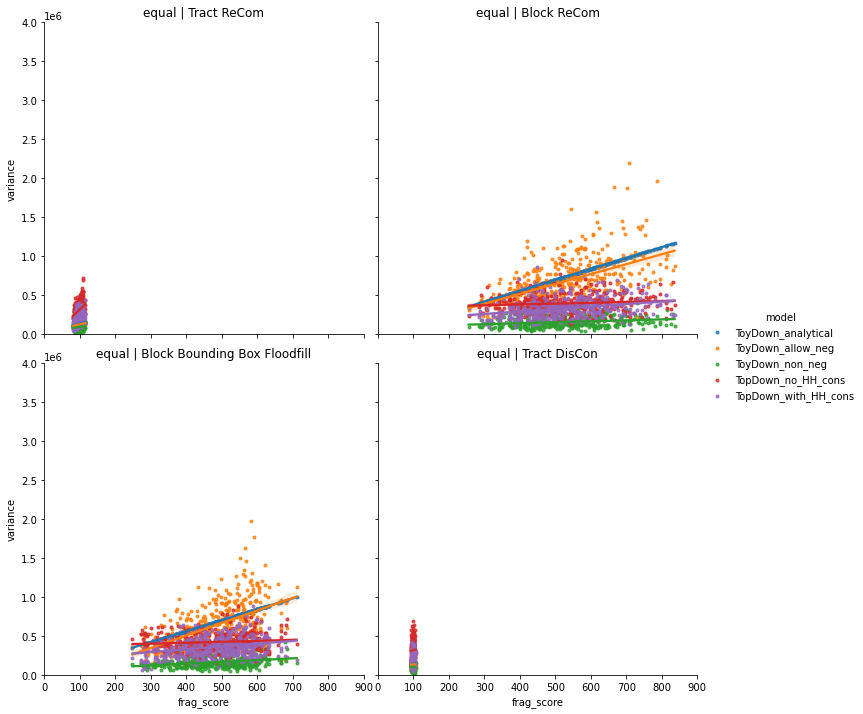

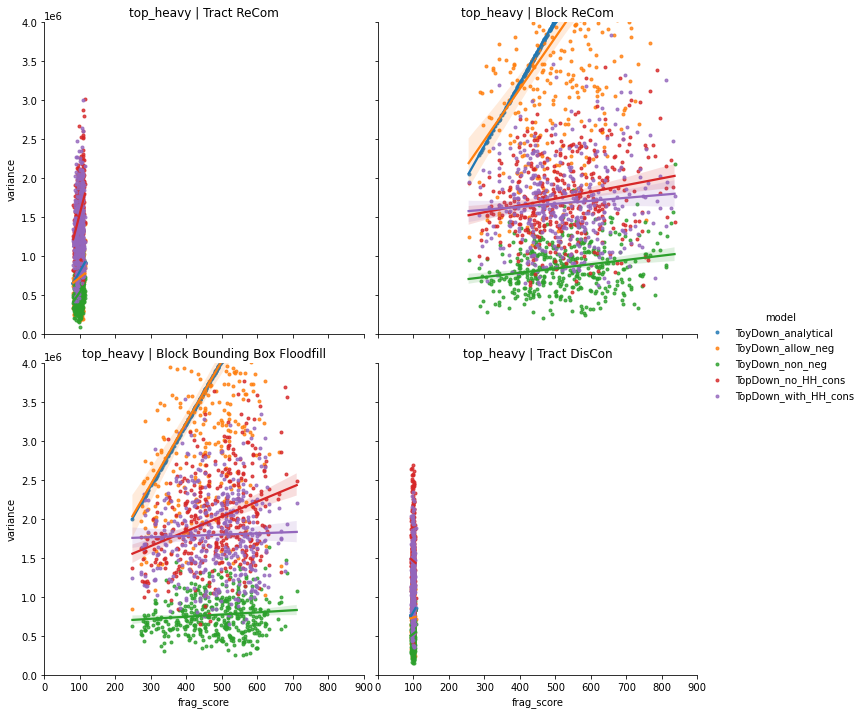

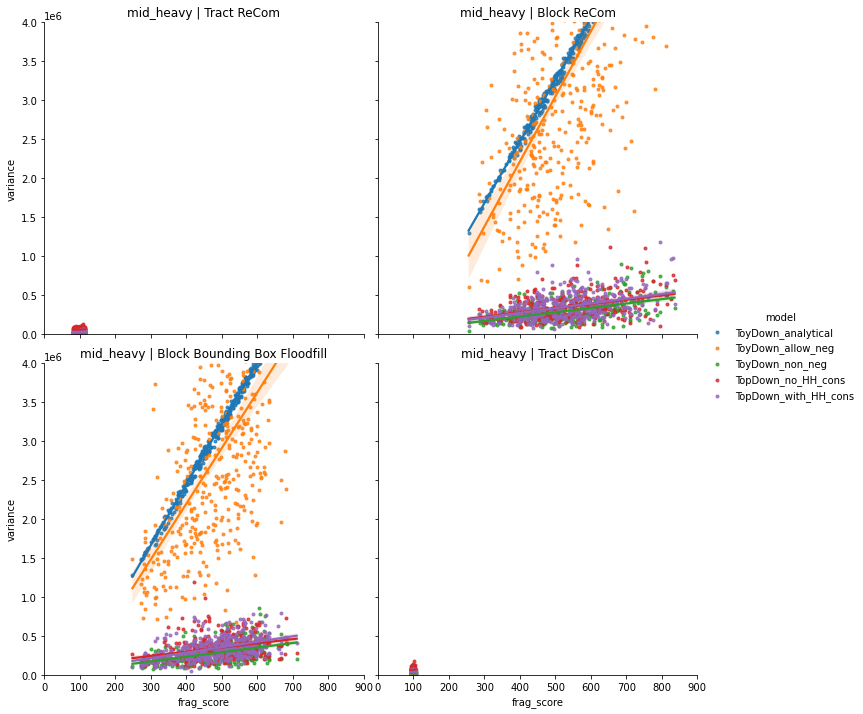

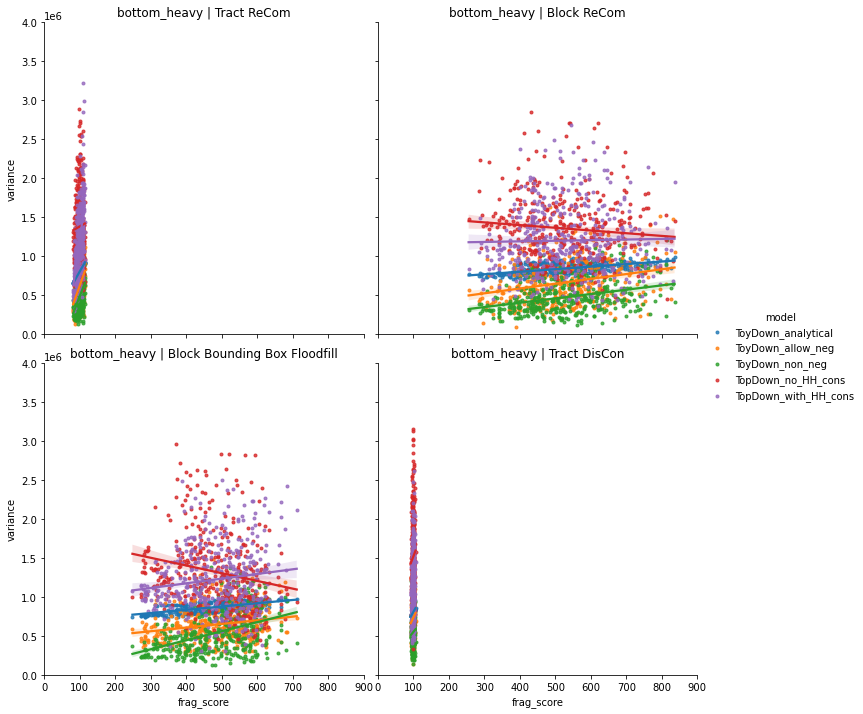

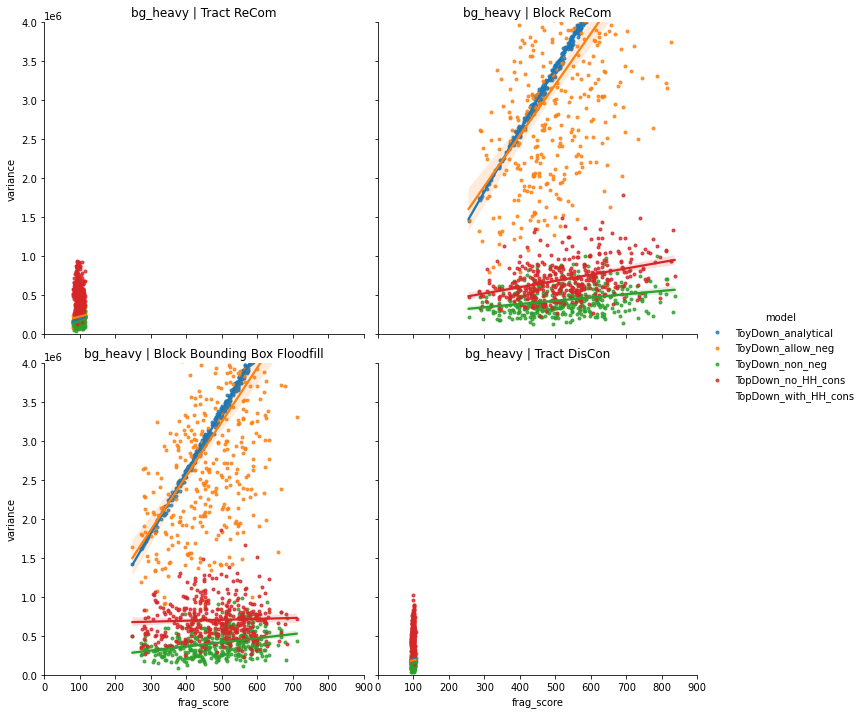

In [302]:
pp = PdfPages('fragscore_v_vars_wout_block_discon.pdf')

for split in ["equal", "top_heavy", "mid_heavy", "bottom_heavy", "bg_heavy"]:
    fig = sns.lmplot(data=df.query("split == @split"), aspect=1, markers=".",
                     x="frag_score", y="variance", hue="model", col='district_type', col_wrap=2,
                     col_order=['tract_recom', 'block_recom', 'block_bb', 'tract_discon'],
                     hue_order=['ToyDown_analytical', 'ToyDown_allow_neg', 'ToyDown_non_neg', 
                                'TopDown_no_HH_cons','TopDown_with_HH_cons'])
    [ax.set_xlim(0,900) for ax in fig.fig.axes]
    [ax.set_ylim(0,4000000) for ax in fig.fig.axes]
    district_gens = ["Tract ReCom", "Block ReCom", "Block Bounding Box Floodfill", 
                     "Tract DisCon", "Block DisCon"]
    [fig.fig.axes[i].set_title("{} | {}".format(split, district_gens[i])) for i in range(4)]
    fig.fig.savefig(pp, format='pdf')
pp.close()

### With Block Discon

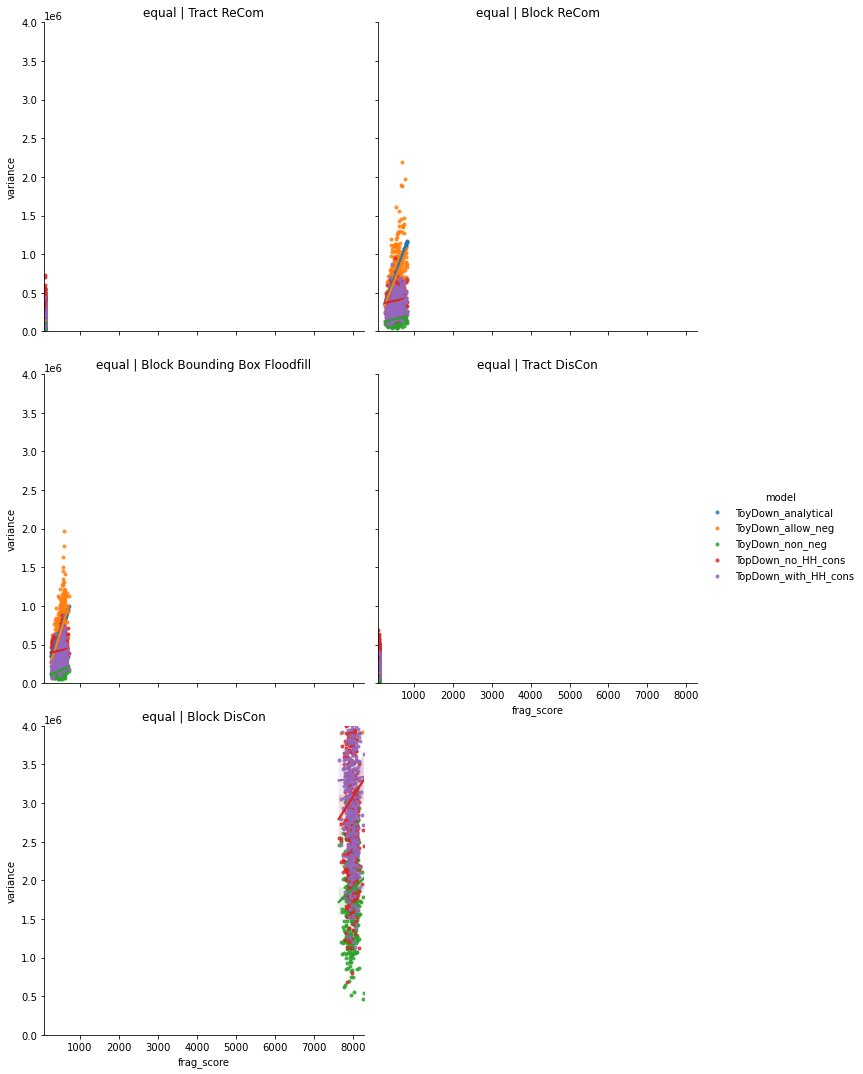

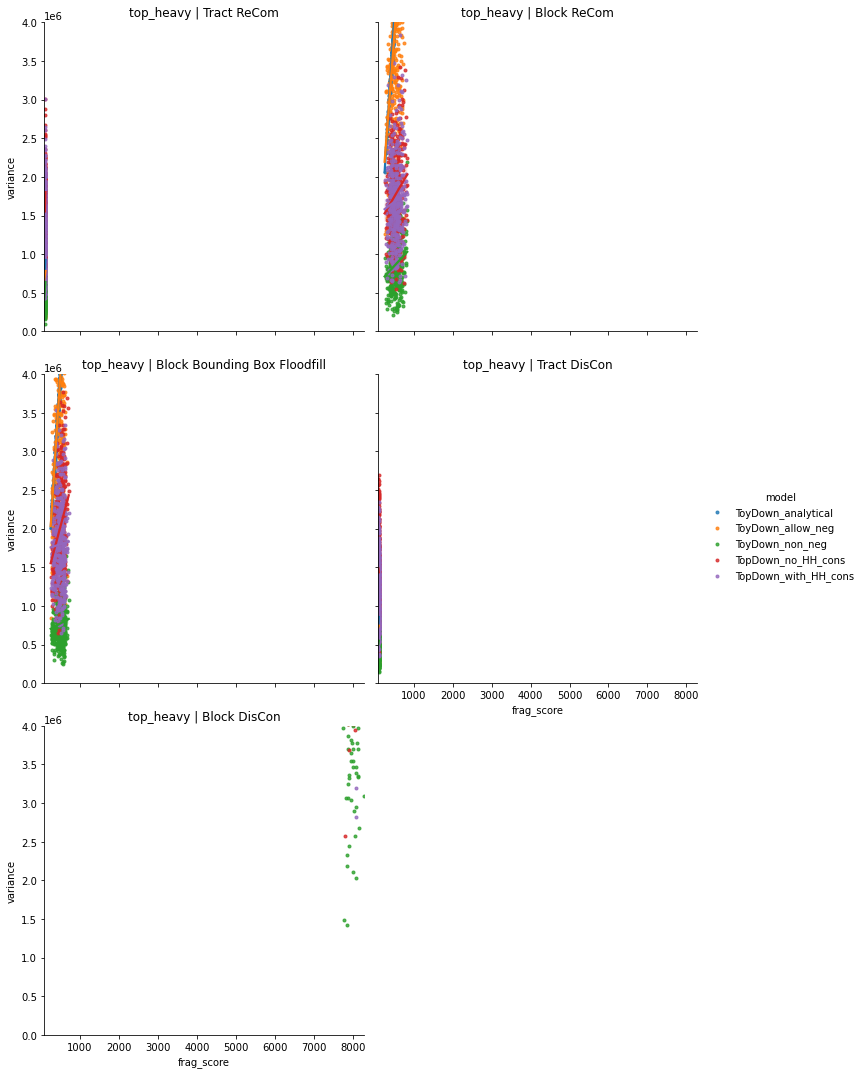

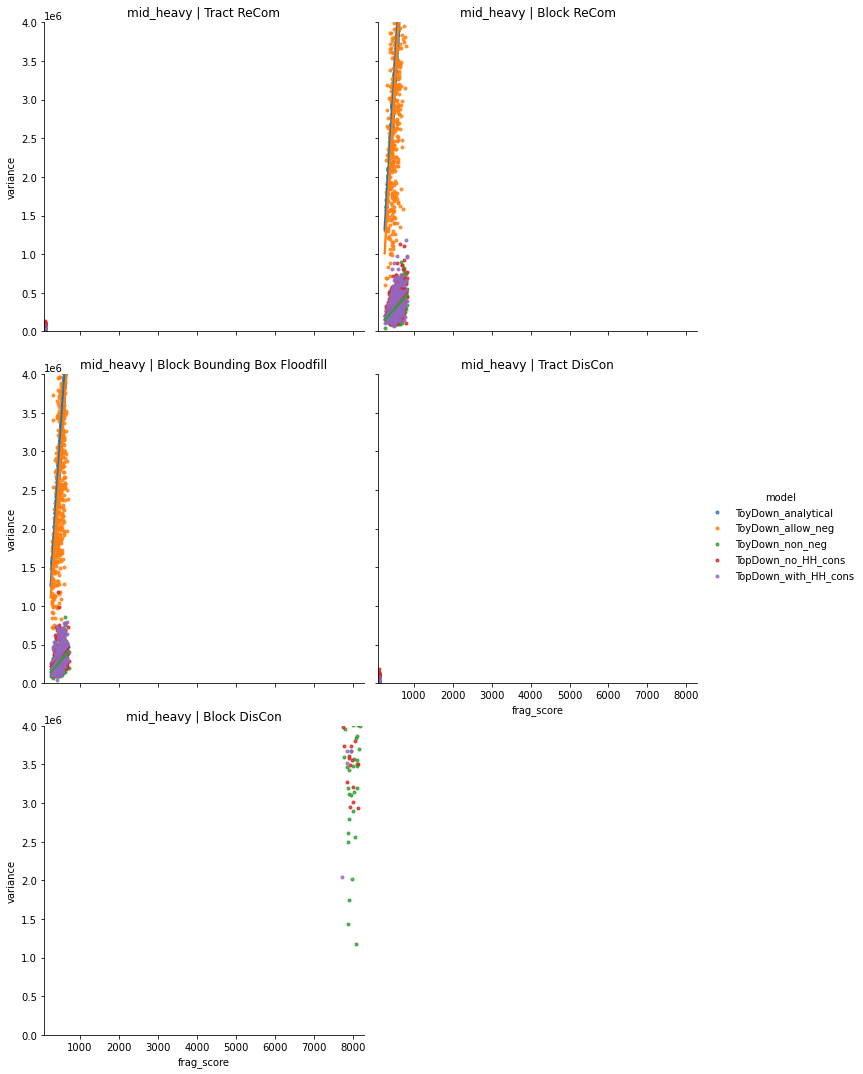

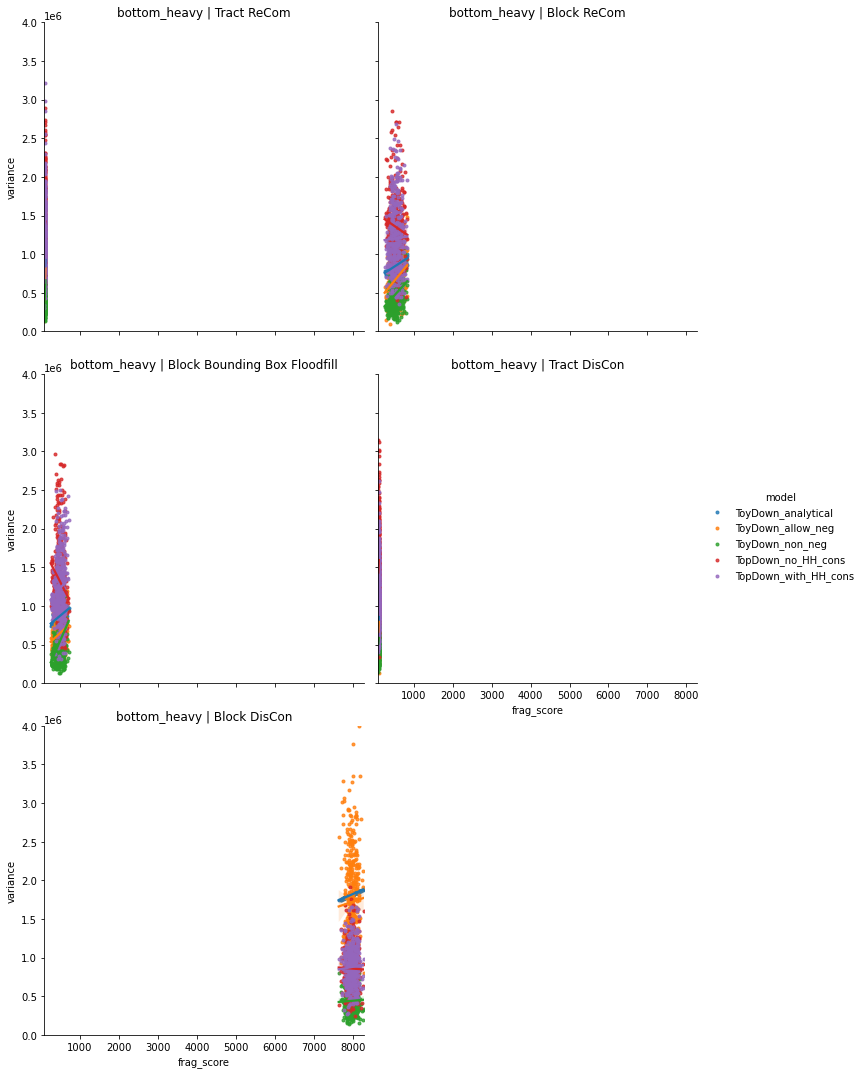

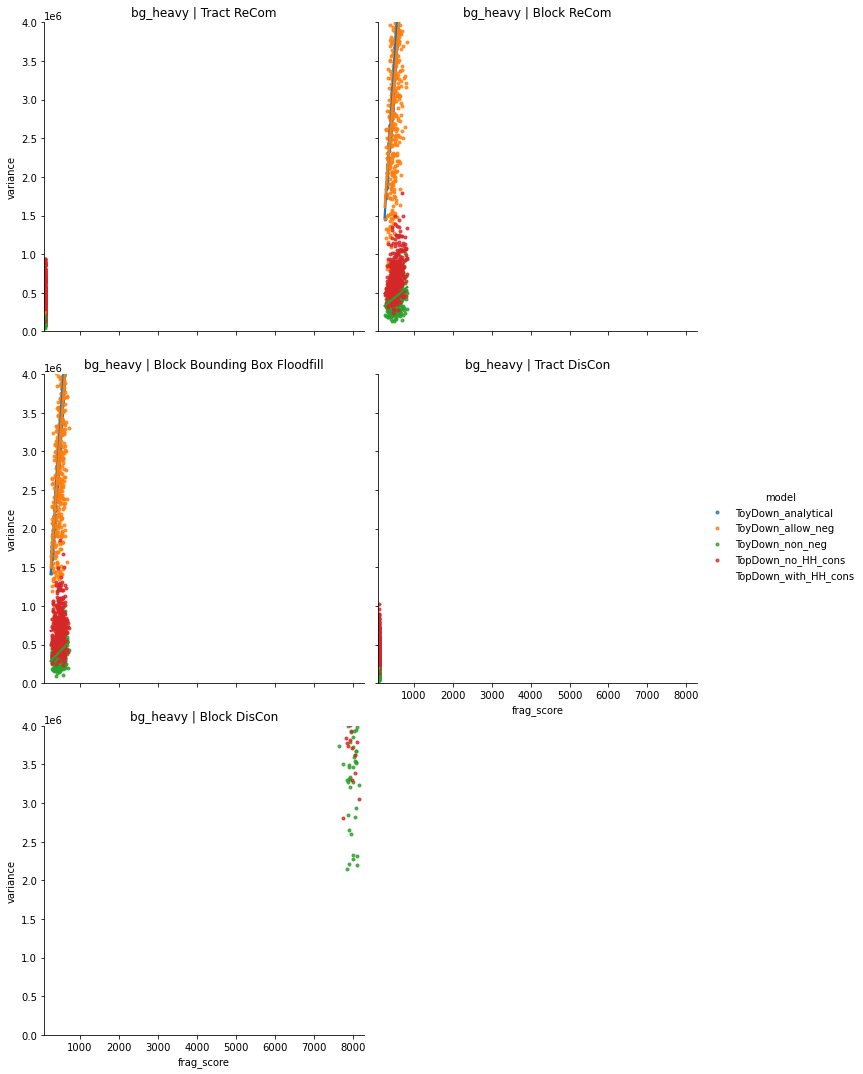

In [303]:
pp = PdfPages('fragscore_v_vars_w_block_discon.pdf')

for split in ["equal", "top_heavy", "mid_heavy", "bottom_heavy", "bg_heavy"]:
    fig = sns.lmplot(data=df.query("split == @split"), aspect=1, markers=".",
                     x="frag_score", y="variance", hue="model", col='district_type', col_wrap=2,
#                      col_order=['tract_recom', 'block_recom', 'block_bb', 'tract_discon'],
                     hue_order=['ToyDown_analytical', 'ToyDown_allow_neg', 'ToyDown_non_neg', 
                                'TopDown_no_HH_cons','TopDown_with_HH_cons'])
#     [ax.set_xlim(0,900) for ax in fig.fig.axes]
    [ax.set_ylim(0,4000000) for ax in fig.fig.axes]
    district_gens = ["Tract ReCom", "Block ReCom", "Block Bounding Box Floodfill", 
                     "Tract DisCon", "Block DisCon"]
    [fig.fig.axes[i].set_title("{} | {}".format(split, district_gens[i])) for i in range(5)]
    fig.fig.savefig(pp, format='pdf')
pp.close()

## Scratch

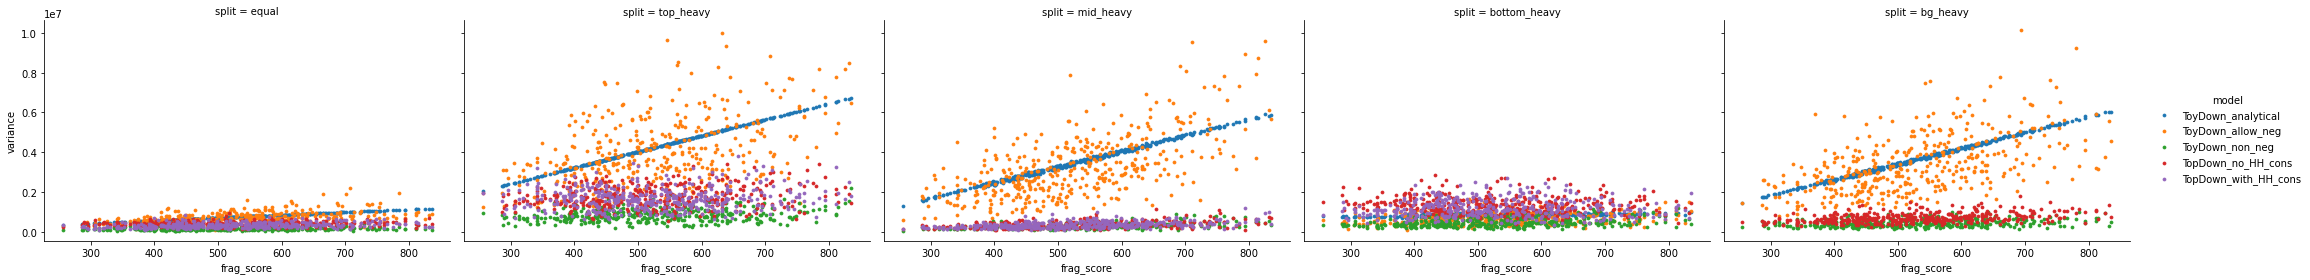

In [275]:
fig = sns.FacetGrid(block_recom, col="split",  hue="model", height=4, aspect=1.5)
fig = (fig.map(sns.scatterplot, "frag_score", "variance", 
               marker=".", edgecolor=None).add_legend())

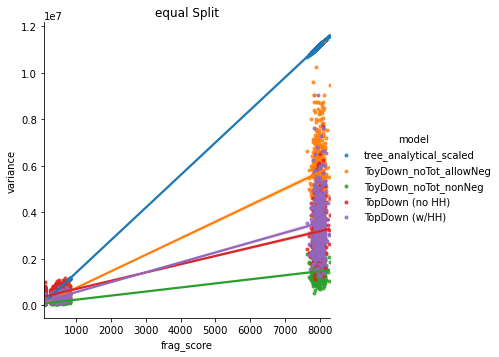

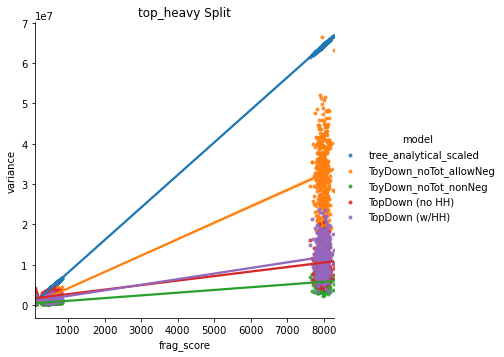

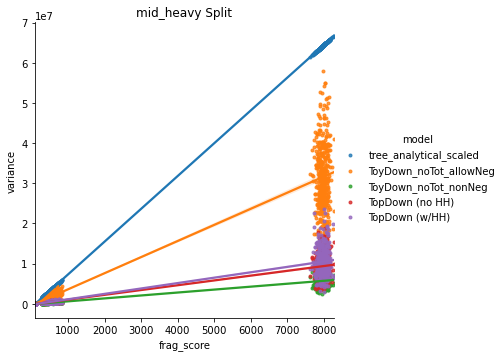

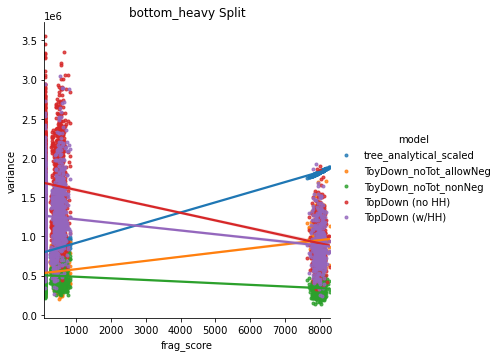

In [207]:
for split in ["equal", "top_heavy", "mid_heavy", "bottom_heavy"]:
    fig = sns.lmplot(data=df.query("split == @split"), aspect=1, markers=".",
                     x="frag_score", y="variance", hue="model", 
                     hue_order=["tree_analytical_scaled", "ToyDown_noTot_allowNeg", 
                                "ToyDown_noTot_nonNeg", "TopDown (no HH)", "TopDown (w/HH)"])
    fig.fig.axes[0].set_title("{} Split".format(split))
    plt.savefig("recon-plots/frag_v_var_all_models_{}_split.png".format(split), 
            dpi=200, bbox_inches="tight")

In [208]:
df1 = df[df['model'].isin(["ToyDown_noTot_allowNeg", 
                     "ToyDown_noTot_nonNeg", "TopDown (no HH)", "TopDown (w/HH)"])]

<Figure size 576x432 with 0 Axes>

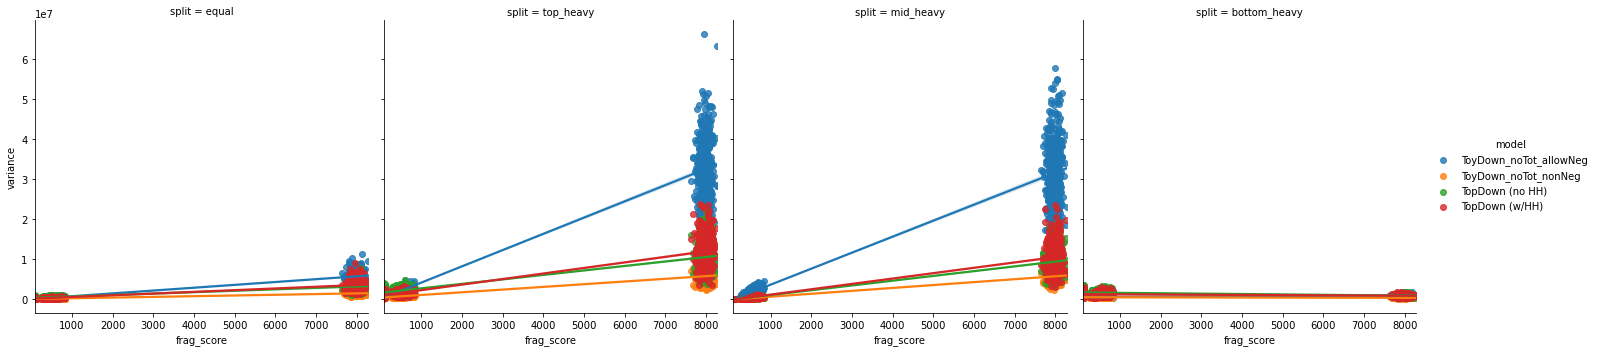

In [210]:
plt.figure(figsize=(8,6))

fig = sns.lmplot(data=df1, x="frag_score", y="variance", 
                      hue="model", col="split",
                      hue_order=["ToyDown_noTot_allowNeg", 
                                 "ToyDown_noTot_nonNeg", "TopDown (no HH)", "TopDown (w/HH)"])
# [ax.set_xlim(0,900) for ax in fig.fig.axes]
# [ax.set_ylim(0,4000000) for ax in fig.fig.axes]

In [261]:
df.model = df.model.apply(lambda s: 'TopDown (no HH)' if s == 'TopDown (no/HH) | BG_Weighted' else s)

In [262]:
df.query("model == 'TopDown (no HH)'").split.unique()

array(['equal', 'top_heavy', 'mid_heavy', 'bottom_heavy', 'bg_weighted'],
      dtype=object)

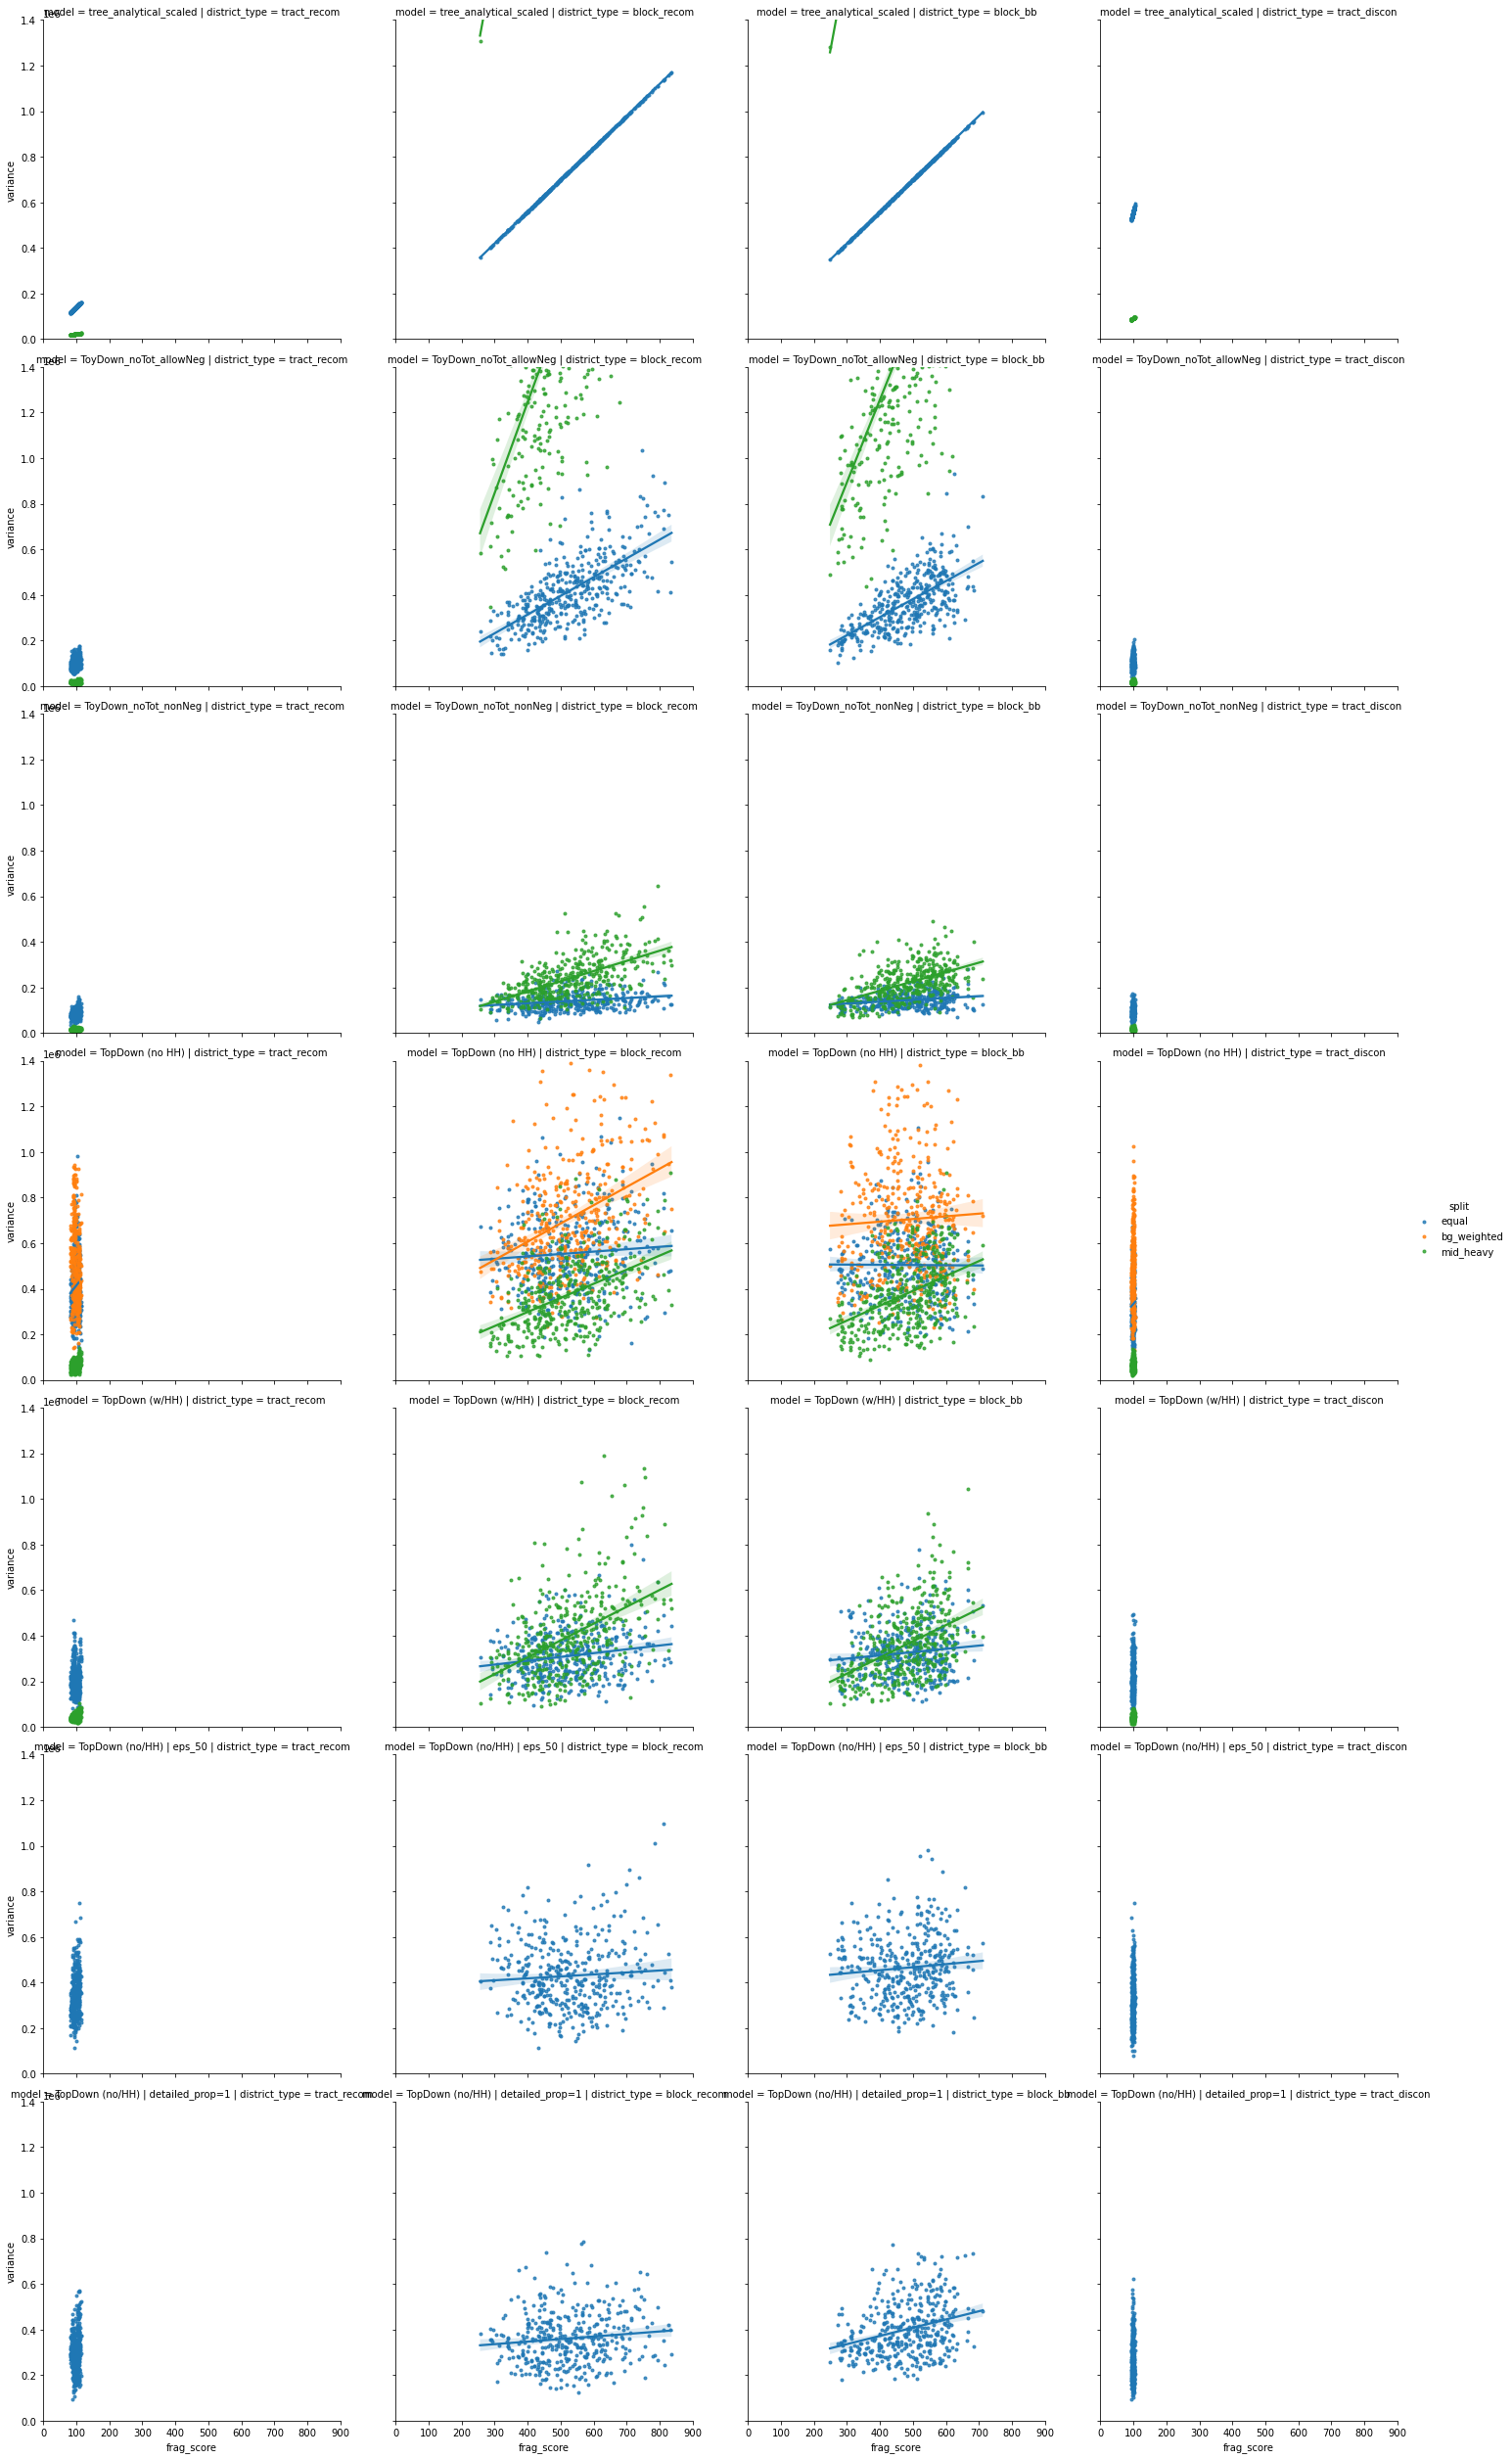

In [268]:
fig = sns.lmplot(data=df, aspect=1, markers=".",
                     x="frag_score", y="variance", hue="split", col='district_type',
                     row="model",
                     hue_order=['equal', 'bg_weighted','mid_heavy'],
                     col_order=['tract_recom', 'block_recom', 'block_bb', 'tract_discon'],
                     row_order=["tree_analytical_scaled", "ToyDown_noTot_allowNeg", 
                                "ToyDown_noTot_nonNeg", "TopDown (no HH)", "TopDown (w/HH)", 
                                'TopDown (no/HH) | eps_50','TopDown (no/HH) | detailed_prop=1'])
[ax.set_xlim(0,900) for ax in fig.fig.axes]
[ax.set_ylim(0,1400000) for ax in fig.fig.axes]
fig.fig.savefig("special_top_down_runs_by_dist_type_and_model.png", dpi=200, bbox_inches="tight")

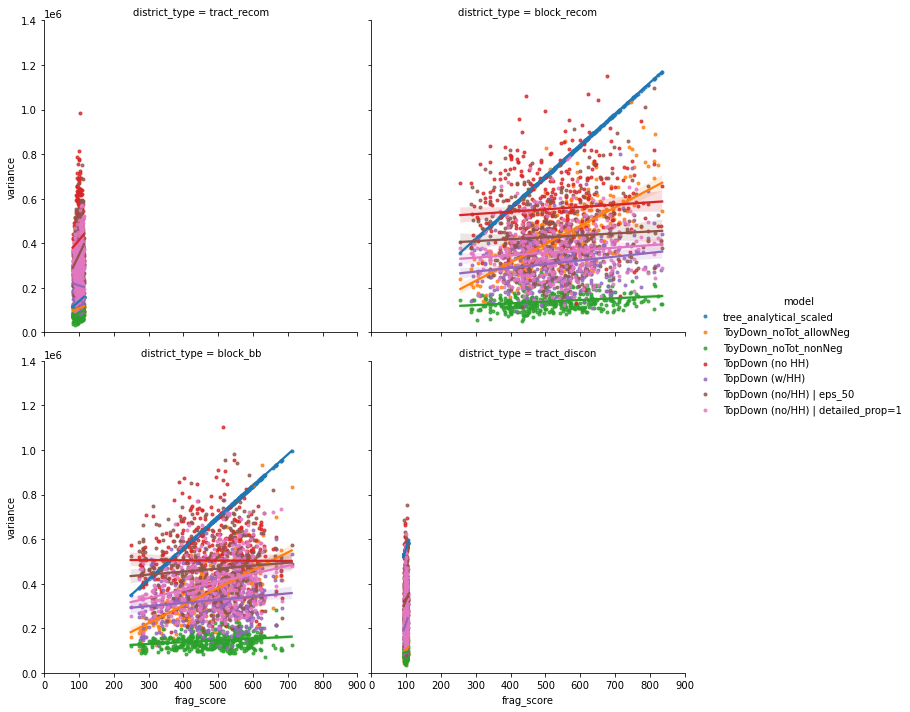

In [267]:
fig = sns.lmplot(data=df.query("split == 'equal'"), aspect=1, markers=".",
                     x="frag_score", y="variance", hue="model", col='district_type', col_wrap=2,
                     col_order=['tract_recom', 'block_recom', 'block_bb', 'tract_discon'],
                     hue_order=["tree_analytical_scaled", "ToyDown_noTot_allowNeg", 
                                "ToyDown_noTot_nonNeg", "TopDown (no HH)", "TopDown (w/HH)", 
                                'TopDown (no/HH) | eps_50','TopDown (no/HH) | detailed_prop=1'])
[ax.set_xlim(0,900) for ax in fig.fig.axes]
[ax.set_ylim(0,1400000) for ax in fig.fig.axes]
fig.fig.savefig("special_top_down_runs_by_dist_type.png", dpi=200, bbox_inches="tight")

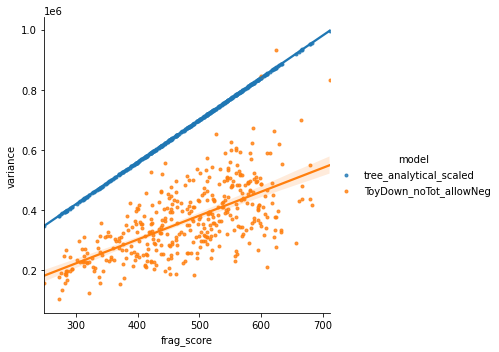

In [239]:
fig = sns.lmplot(data=df.query("split == 'equal' and district_type == 'block_bb'"), aspect=1, markers=".",
                     x="frag_score", y="variance", hue="model",
                     hue_order=["tree_analytical_scaled", "ToyDown_noTot_allowNeg"])

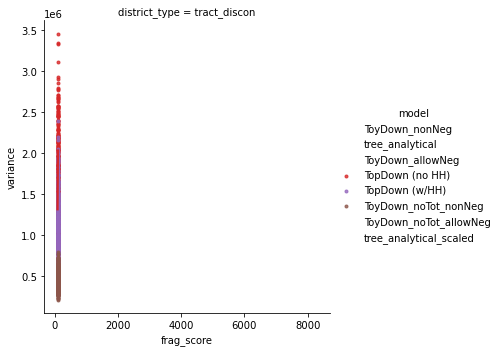

In [159]:
sns.lmplot(data=df.query("split == @split"), aspect=1, markers=".",
                     x="frag_score", y="variance", hue="model", col='district_type', col_order=["tract_discon"],
#                      hue_order=["tree_analytical_scaled", "ToyDown_noTot_allowNeg", 
#                                 "ToyDown_noTot_nonNeg", "TopDown (no HH)", "TopDown (w/HH)"]))
          )

In [139]:
df.district_type.unique()

array(['tract_recom', 'block_recom', 'block_bb', 'tract_discon',
       'block_discon'], dtype=object)